In [222]:
# Make necessary imports

import numpy as np
import mne
from mne import io, read_proj, read_selection
from mne.datasets import sample
from mne.time_frequency import psd_multitaper
print(__doc__)
import pyedflib
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import array as array
from astropy.io import ascii
import math
import statistics

Automatically created module for IPython interactive environment


Action items for the summer:
    1. Read in ASCII file without using a ton of memory space
    2. Read in a whole cohort of ASCII files without space issues as raw data
    3. Analyze power spectral densities between two genotypes; Analyze power bands (binned frequencies) between two genotypes
        a. Figures: Power spectral density plot and summed densities by power band bins 
    4. For manuscript it would be cool to make representative spectograms https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
    5. Train code to differentiate between sleep and wake from manual markers, then learn frequency band ratios associated with sleep stages
    6. Run sleep analysis module on cohorts of data and compare genotypes
        a. Figures: Mean time sleep/wake, frequency of cycles, latencies to cycles, temparature throughout
    7. Run spiking analysis on EEG in parallel with EMG and recognize that spikes in EMG results in artifact in EEG and won't include in spike count
        a. Figures: Mean spikes per genotype, spiking patterns and/or shape
    8. Have manual scoring of sleep spindles
    9. Train code to recognize sleep spindles, then learn the pattern associated with them
    10. Run spindle analysis module on cohorts of data and compare genotypes
        a. Figures: Mean spikes per genotype, spiking patterns and/or shape

## Raw Data:

In [223]:
# Goal = Get raw data. We took several approaches:
# 1. Reading in an EDF (European Data Format) file as a pandas dataframe.
# EDFs are commonly used to share time series medical data. This was the most compact file type available.
#         Advantages: Data in an easy to work with df, easier to work with for stats
#         Disadvantages: Doesnt't work as nicely with mne's quick EEG analysis tools
# 2. Reading in an EDF file using mne
#         Advantages: Quick, easy to use
#         Disadvantages: Less easy to manipulate various parameters, doesn't work super well with general dfs
# 3. Reading in the complete raw ASCII file with all parameters (EEG, EMG, Activity, Temp, Signal Strength)
#         Advantages: It is all the raw data, what is ultimatley necessary in the future
#         Disadvantages: It is HUGE
# The ASCII file is what we ultimatley want this module to use for the lab

#### 1. Create a pandas data frame using a standard EDF reader

In [224]:
class EDF_to_df():
    def __init__(self, edf_file):
        self.edf_file = edf_file
    
    # Build time column off of starting timestamp by sampling rate
    def build_time_column(self, start_time, sample_rate, n):
        time_delta_nanosecond = np.linspace(0, (1/sample_rate) * 1000 * 1000, n)
        return(np.datetime64(start_time) + time_delta_nanosecond.astype('timedelta64[ns]'))
    
    # Create df with channels and built time column
    def read_channels_as_df(self):
        f = pyedflib.EdfReader(self.edf_file)
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        time = build_time_column(f.getStartdatetime(), 500, f.getNSamples()[0])
        sigbufs = np.zeros((f.getNSamples()[0], n))
        for i in np.arange(n):
             sigbufs[:, i] = f.readSignal(i)
        self.raw_data = pd.DataFrame(sigbufs, columns = signal_labels)
        self.raw_data['Time'] = time
        return(self.raw_data)
    
    # Be able to visualize the head of the dataframe
    def head(self):
        return(self.raw_data.head())
   
    # Plot the data from each channel
    def plot_eeg(self):
        return(self.raw_data.EEG1.plot())
    def plot_act(self):
        return(self.raw_data.Act1.plot())

       Act1      EEG1                Time
0  0.032003 -0.000001 2018-09-08 19:54:13
1  0.032003  0.000013 2018-09-08 19:54:13
2  0.032003  0.000024 2018-09-08 19:54:13
3  0.032003  0.000022 2018-09-08 19:54:13
4  0.032003  0.000015 2018-09-08 19:54:13
AxesSubplot(0.125,0.125;0.775x0.755)


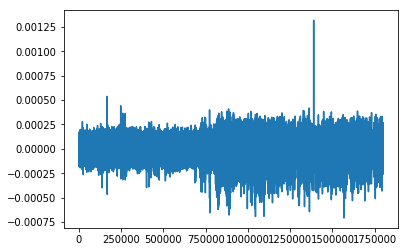

In [225]:
# Employing the class
edf_file = "/Users/liz/Box Sync/School/Spring 2019/Programming/Final Project/Portion.edf"
df = EDF_to_df(edf_file)
df.read_channels_as_df()

print(df.head())
print(df.plot_eeg())

AxesSubplot(0.125,0.125;0.775x0.755)


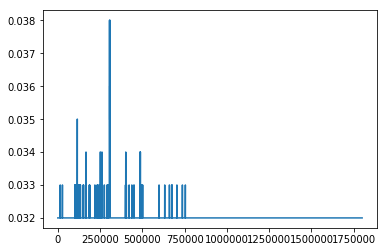

In [226]:
print(df.plot_act())

#### 2. Read in data using mnem

In [227]:
raw = mne.io.read_raw_edf("/Users/liz/Box Sync/School/Spring 2019/Programming/Final Project/Portion.edf", preload=True)

Extracting EDF parameters from /Users/liz/Box Sync/School/Spring 2019/Programming/Final Project/Portion.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1799999  =      0.000 ...  3599.998 secs...


In [228]:
raw.info

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Act1, EEG1
    chs : list | 2 items (EEG: 2)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : tuple | 2018-09-08 19:54:13 GMT
    nchan : int | 2
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : NoneType
>

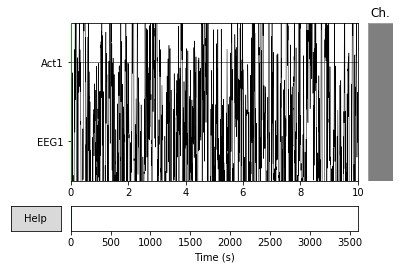

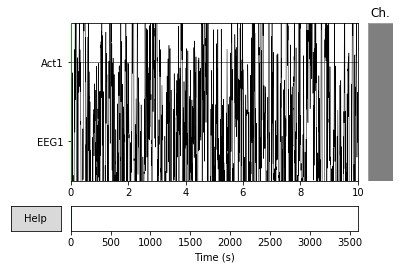

In [229]:
raw.plot()

#### 3. Future Direction: Read in ASCII file

## Class 1: Preprocessing

#### 0-50 Hz and 10-15 Hz Bandpass Filters

In [230]:
# Goal = Filter out high frequencies
# Name = noise_preprocess
# Input = data “raw”
# Output = data “bp0-50"

# Goal = Filter out frequencies above/below frequencies where sleep spindles often occur
# Name = bp10_15
# Input = dataframe “raw_data”
# Output = dataframe “bp10-15"

In [231]:
class preprocess():
    def __init__(self, data):
        self.data = data
    
    # Convert data into MNE format to use MNE's filter functionality
    # But since MNE's filters are "in-place," reload data before each
    
    # Preprocess noise with 0-50 Hz filter
    def noise_preprocess(self):
        self.mne_data = mne.io.read_raw_edf(self.data, preload=True)
        self.bp0_50 = self.mne_data.filter(None, 50.)
        return(self.bp0_50)
    # Preprocess for spindles with 10-15 Hz filter
    def spindle_preprocess(self):
        self.mne_data = mne.io.read_raw_edf(self.data, preload=True)
        self.bp10_15 = self.mne_data.filter(10, 15.)
        return(self.bp10_15)
    
    # Plot the preprocessed data
    def plot_noise_preprocessed(self):
        return(self.bp0_50.plot())
    def plot_spindle_preprocessed(self):
        return(self.bp10_15.plot())

Extracting EDF parameters from /Users/liz/Box Sync/School/Spring 2019/Programming/Final Project/Portion.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1799999  =      0.000 ...  3599.998 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 133 samples (0.266 sec)



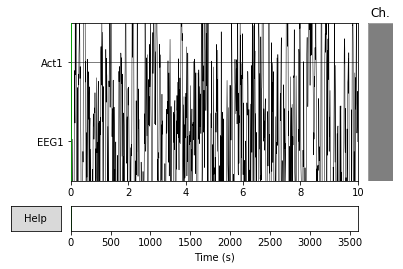

Extracting EDF parameters from /Users/liz/Box Sync/School/Spring 2019/Programming/Final Project/Portion.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1799999  =      0.000 ...  3599.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 661 samples (1.322 sec)



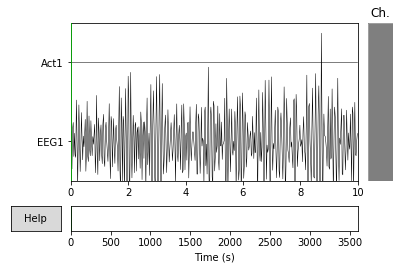

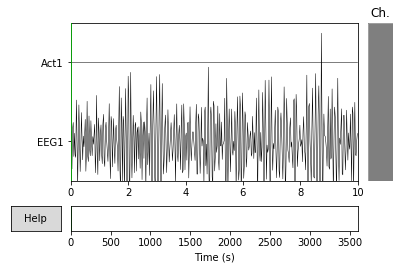

In [233]:
# Employing the class
data = "/Users/liz/Box Sync/School/Spring 2019/Programming/Final Project/Portion.edf"

eeg = preprocess(data)
eeg.noise_preprocess()
eeg.plot_noise_preprocessed()

spindles = preprocess(data)
spindles.spindle_preprocess()
spindles.plot_spindle_preprocessed()

## Class 2: Biomarker Measures

#### Power Spectral Density Plots

In [234]:
# Goal = Power spectral density plots
# Name = “plot_psd"
# Input = preprocessed data “bp0-50”
# Output = Power spectral density plots (they have different approaches to calculating PSD)

In [235]:
class plot_psd():
    def __init__(self, data):
        self.data = data
    
    # Plot PSD via multitaper method
    def plot_multitaperPSD(self):
        f, ax = plt.subplots()
        psds, freqs = psd_multitaper(self.data, low_bias=True, proj=True, n_jobs=1)
        psds = 10 * np.log10(psds)
        psds_mean = psds.mean(0)
        psds_std = psds.std(0)
        fmin, fmax = 1, 60
        ax.plot(freqs, psds_mean, color='k')
        ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std, color='k', alpha=.5)
        ax.set(title='Multitaper PSD', xlabel='Frequency', ylabel='Power Spectral Density (dB)')
        plt.show()
    
    # Plot PSD via Welch's method
    def plot_welchPSD(self):
        f, ax = plt.subplots()
        psds, freqs = mne.time_frequency.psd_welch(self.data)
        psds = 10 * np.log10(psds)
        psds_mean = psds.mean(0)
        psds_std = psds.std(0)
        ax.plot(freqs, psds_mean, color='k')
        ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std, color='k', alpha=.5)
        ax.set(title='Welch PSD', xlabel='Frequency',ylabel='Power Spectral Density (dB)')
        plt.show()

In [246]:
# Employing the class

pb0_50 = preprocess(data)
pb0_50.noise_preprocess()
psd = plot_psd(pb0_50)
#psd.plot_multitaperPSD()

Extracting EDF parameters from /Users/liz/Box Sync/School/Spring 2019/Programming/Final Project/Portion.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1799999  =      0.000 ...  3599.998 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 133 samples (0.266 sec)



In [247]:
#psd.plot_welchPSD()

#### Power Band Breakdown and Sleep/Wake Cycles

In [248]:
# Goal = Train the program to detect sleep/wake cycles in power band breakdown based on data patterns and handscored training data 
# Name = "sleep_cycles"
# Input = dataframe “power_bands” and training data (Nyc’s handscored sleep/wake cycles: dataframe containing time, power bands, and sleep/wake in 30 sec bins)
# Output = dataframe “sleep_wake” containing time (30-sec bins) and associated cycle

In [249]:
# Defining power bands and averages over time bins
# As a rule, whether awake or asleep lower frequencies have a higher density than higher frequencies
# When manually scoring sleep, lower fequencies (delta, theta, alpha) are at a much higher ratio of the total signal than higher frequencies
# When awake, higher frequencies (beta, gamma) make up more of the signal density, but are still lower than delta, theta, alpha
# I don't actually know what those ratios look like and am using these functions as a way to understand this pattern

bands = (
    ('delta', 0.5, 4.5),
    ('theta', 4.5, 8.5),
    ('alpha', 8.5, 11.5),
    ('sigma', 11.5, 15.5),
    ('beta', 15.5, 30),
    ('gamma', 30, 50)
)

def avg_power(raw, tmin, tmax, fmin, fmax):
    psds, freqs = psd_multitaper(raw, low_bias=True, tmin=tmin, tmax=tmax,
               fmin=fmin, fmax=fmax, proj=True, picks='eeg',
               n_jobs=2)
    return psds.mean()

def get_power_bands(raw, tmin, tmax):
    return dict((band, avg_power(raw, tmin, tmax, fmin, fmax)) for band, fmin, fmax in bands)

In [250]:
# Calculate the ratio of high to low frequencies 
def pb_ratio(power_bands):
    pb_vals = np.fromiter(power_bands.values(), dtype=float)
    low_freq = (sum(pb_vals[0:3])/sum(pb_vals))
    high_freq = (sum(pb_vals[4:6])/sum(pb_vals))
    ratio = low_freq - high_freq
    return ratio   

In [251]:
# Generate window (start, end) tuples of a given width
# to cover the length of a signal
def make_windows(window_size, end):
    num_windows = math.ceil(end / window_size)
    return [(x * window_size, min((x * window_size) + window_size, end)) for x in range(0, num_windows)]

def pb_ratio_for_window(raw_data, tmin, tmax):
    power_bands = get_power_bands(raw_data, tmin, tmax)
    ratio = pb_ratio(power_bands)
    return ratio

# Visualize the ratio changes over EEG data
# Where power band densities are larger = sleep; where power band densities are smaller = wake
def pb_over_signal(raw_data, window_size):
    signal_duration = 3600 # Figure out how to extract this
    windows = make_windows(window_size, signal_duration)
    ratios = [(tmin, pb_ratio_for_window(raw_data, tmin, tmax)) for (tmin, tmax) in windows]
    return ratios

In [252]:
# Assign binary number 1 for wake cycle and 2 for sleep cycle (used later in analysis)
# Need to decide on what constitutes sleep vs. wake

#### Spiking Activity

In [253]:
# Goal = Calculate mean amplitude for each 30-sec timebin and count spikes within the timebin (spike defined as amplitude 2.5 standard deviations above the mean of that bin)
# Name = “spike_count"
# Input = dataframe “bp0-50”
# Output = dataframe “spikes”
def count_spikes(raw, tmin, tmax):
    slice = raw.copy().pick('EEG1').crop(tmin, tmax)
    print(np.mean(slice[0]))
    
count_spikes(raw, 0, 30)

[[-6.15024262e-07  1.00658625e-03  2.01216144e-03 ...  1.49980605e+01
   1.49990541e+01  1.50000461e+01]]


Future direction: Visualize the mean amplitude changes over EEG data

## Class 3: Analysis of Biomarker Measures

#### Sleep/wake cycles

In [254]:
# Goal = To look at general statistics (average time spent in, latency to, longest duration, shortest duration, frequency of each sleep/wake cycle)
# Name = "sleep_wake_analysis"
# Input = "array of sleep/wake data"
# Output = statistics table 

In [255]:
class sleep_wake_analysis():
    def __init__(self, data):
        self.data = data
    
    # Be able to calculate the number of transitions between sleep and wake
    def get_num_transitions(self):
        self.num_sleep_to_wake = (self.data[:-1] > self.data[1:]).sum()
        self.num_wake_to_sleep = (self.data[:-1] < self.data[1:]).sum()
        self.total_num_transitions = self.num_sleep_to_wake + self.num_wake_to_sleep
        return(self.total_num_transitions)
    
    # Calculate the number of total cycles (sleep + wake)
    def get_num_cycles(self):
        self.total_num_cycles = self.total_num_transitions + 1
        return(self.total_num_cycles)
    
    # Also be able to get the number of each
    def get_num_cycles_sleep_wake(self):
        if self.data[len(self.data)-1] == 1:
            self.num_sleep = self.num_sleep_to_wake
            self.num_wake = self.num_wake_to_sleep + 1
        if self.data[len(self.data)-1] == 2:
            self.num_sleep = self.num_sleep_to_wake + 1
            self.num_wake = self.num_wake_to_sleep
        return(self.num_sleep, self.num_wake)
    
    # Locate the transitions within the data
    def get_transitions_loc(self):
        d = np.diff(self.data)
        self.loc_wake_to_sleep = np.where(d == 1)[0] + 1
        self.loc_sleep_to_wake = np.where(d == -1)[0] + 1
        locs = np.append(self.loc_wake_to_sleep, self.loc_sleep_to_wake)
        self.all_trans_locs = np.sort(locs)
        return(self.all_trans_locs)
    
    # Determine the latency to sleep and latency to wake
    def get_latencies_sleep_wake(self):
        if self.data[0] == 1:
            self.latency_wake = 0
            self.latency_sleep = self.loc_wake_to_sleep[0]
            return(self.latency_sleep, self.latency_wake)
        if self.data[0] == 2:
            self.latency_sleep = 0
            self.latency_wake = self.loc_sleep_to_wake[0]
            return(self.latency_sleep, self.latency_wake)
    
    # Calculate the length of each cycle
    def get_cycle_lengths(self):
        self.cycle_lengths = []
        self.cycle_lengths.append(self.all_trans_locs[0])
        for n in range(1, len(self.all_trans_locs)):
            self.cycle_lengths.append(self.all_trans_locs[n] - self.all_trans_locs[n-1])
        return(self.cycle_lengths)
    
    # Specifically calculate the length of each sleep cycle
    def get_cycle_lengths_sleep(self):
        self.sleep_cycle_lengths = []
        self.sleep_cycle_lengths.append(self.loc_sleep_to_wake[0])
        for n in range(1, len(self.loc_sleep_to_wake)):
            self.sleep_cycle_lengths.append(self.loc_sleep_to_wake[n] - self.loc_sleep_to_wake[n-1])
        return(self.sleep_cycle_lengths)
    
    # Specifically calculate the length of each wake cycle
    def get_cycle_lengths_wake(self):
        self.wake_cycle_lengths = []
        self.wake_cycle_lengths.append(self.loc_wake_to_sleep[0])
        for n in range(1, len(self.loc_wake_to_sleep)):
            self.wake_cycle_lengths.append(self.loc_wake_to_sleep[n] - self.loc_wake_to_sleep[n-1])
        return(self.wake_cycle_lengths)

In [258]:
# In this example array, 2=sleep and 1=wake
x = np.array([2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1])

obj = sleep_wake_analysis(x)
print(obj.get_num_transitions())
print(obj.get_num_cycles())
print(obj.get_num_cycles_sleep_wake())
print(obj.get_transitions_loc())
print(obj.get_latencies_sleep_wake())
print(obj.get_cycle_lengths_sleep())
print(obj.get_cycle_lengths_wake())

5
6
(3, 3)
[ 1  3  8  9 10]
(0, 1)
[1, 7, 2]
[3, 6]


In [259]:
# Further analyses can be done using statistics

scl = obj.get_cycle_lengths_sleep()
print(statistics.mean(scl))
print(statistics.stdev(scl))

print(statistics.mode(obj.get_num_cycles_sleep_wake()))

3
3.1622776601683795
3


#### Future Direction: Spiking activity

In [260]:
# Goal = To look at the number of spiking events over a given period of time
# Name = "spike_an"
# Input = "spikes"
# Output = count of spikes per given time bin